# EDA

## Setup Spark and Libraries

In [5]:
import re
import ast
import time
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt

In [6]:
%reload_ext autoreload
%autoreload 2

In [7]:
PWD = !pwd
PWD = PWD[0]

In [8]:
from pyspark.sql import SparkSession
app_name = "final_project"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext

In [9]:
spark

## What is the Input Data?

In [13]:
!head -1 data/dac/train.txt

0	1	1	5	0	1382	4	15	2	181	1	2		2	68fd1e64	80e26c9b	fb936136	7b4723c4	25c83c98	7e0ccccf	de7995b8	1f89b562	a73ee510	a8cd5504	b2cb9c98	37c9c164	2824a5f6	1adce6ef	8ba8b39a	891b62e7	e5ba7672	f54016b9	21ddcdc9	b1252a9d	07b5194c		3a171ecb	c5c50484	e8b83407	9727dd16


The data has previously been loaded into memory and saved as a parquet file because lots of column-wise aggregation was expected

In [10]:
# Load parquet df, save as different name and cache it
parquet_df = spark.read.parquet('data/dac/train-parquet')

In [11]:
parquet_df.printSchema()

root
 |-- _1: string (nullable = true)
 |-- _2: string (nullable = true)
 |-- _3: string (nullable = true)
 |-- _4: string (nullable = true)
 |-- _5: string (nullable = true)
 |-- _6: string (nullable = true)
 |-- _7: string (nullable = true)
 |-- _8: string (nullable = true)
 |-- _9: string (nullable = true)
 |-- _10: string (nullable = true)
 |-- _11: string (nullable = true)
 |-- _12: string (nullable = true)
 |-- _13: string (nullable = true)
 |-- _14: string (nullable = true)
 |-- _15: string (nullable = true)
 |-- _16: string (nullable = true)
 |-- _17: string (nullable = true)
 |-- _18: string (nullable = true)
 |-- _19: string (nullable = true)
 |-- _20: string (nullable = true)
 |-- _21: string (nullable = true)
 |-- _22: string (nullable = true)
 |-- _23: string (nullable = true)
 |-- _24: string (nullable = true)
 |-- _25: string (nullable = true)
 |-- _26: string (nullable = true)
 |-- _27: string (nullable = true)
 |-- _28: string (nullable = true)
 |-- _29: string (nullab

## Transform column names
The column names are transformed to more easily differentiate between columns that are integer or categorical features

In [15]:
int_column_names = [f"int_feat_{i}" for i in range(0, 13)]
cat_column_names = [f"cat_feat_{i}" for i in range(0, 26)]
column_names = ["class"] + int_column_names + cat_column_names
new_columns_df = parquet_df.toDF(*column_names)

## Casting columns
I kind of assumed all the numeric values were integers although I didn't verify that is exactly the case. Should be verify this?

In [16]:
data_types = ["int"] + ["int"] * 13 + ["string"] * 26

In [17]:
for i, data_type in enumerate(data_types):
    new_columns_df = new_columns_df.withColumn(column_names[i], new_columns_df[column_names[i]].cast(data_type))

In [18]:
new_columns_df.printSchema()

root
 |-- class: integer (nullable = true)
 |-- int_feat_0: integer (nullable = true)
 |-- int_feat_1: integer (nullable = true)
 |-- int_feat_2: integer (nullable = true)
 |-- int_feat_3: integer (nullable = true)
 |-- int_feat_4: integer (nullable = true)
 |-- int_feat_5: integer (nullable = true)
 |-- int_feat_6: integer (nullable = true)
 |-- int_feat_7: integer (nullable = true)
 |-- int_feat_8: integer (nullable = true)
 |-- int_feat_9: integer (nullable = true)
 |-- int_feat_10: integer (nullable = true)
 |-- int_feat_11: integer (nullable = true)
 |-- int_feat_12: integer (nullable = true)
 |-- cat_feat_0: string (nullable = true)
 |-- cat_feat_1: string (nullable = true)
 |-- cat_feat_2: string (nullable = true)
 |-- cat_feat_3: string (nullable = true)
 |-- cat_feat_4: string (nullable = true)
 |-- cat_feat_5: string (nullable = true)
 |-- cat_feat_6: string (nullable = true)
 |-- cat_feat_7: string (nullable = true)
 |-- cat_feat_8: string (nullable = true)
 |-- cat_feat_9: 

## Summary Statistics

In [195]:
summary_df = new_columns_df.summary()

In [221]:
summary_df.select('summary', 'int_feat_5').show()

+-------+------------------+
|summary|        int_feat_5|
+-------+------------------+
|  count|          35588289|
|   mean|116.06185085211598|
| stddev|382.56644937124145|
|    min|                 0|
|    25%|                 8|
|    50%|                33|
|    75%|               103|
|    max|            431037|
+-------+------------------+



## How Many Distinct Values in Each Column?

In [19]:
toy_df = spark.createDataFrame([
    [1, "a", "c"],
    [2, "a", "d"],
    [3, "b", "c"],
    [4, "d", "a"],
    [5, "e", "a"],
    [1, "a", "c"],
    [2, "a", "d"],
    [3, "b", "c"],
    [4, "e", "a"],
    [5, "e", "a"]
])

In [113]:
firstDF = spark.range(3).toDF("myCol")
newRow = spark.createDataFrame([[20]])
appended = firstDF.union(newRow)
appended.show()

+-----+
|myCol|
+-----+
|    0|
|    1|
|    2|
|   20|
+-----+



In [114]:
def get_distinct_summary(df, col):
    summary_values = [col]
    summary_values.append(df.select(col).distinct().count())
    
    count_df = df.groupBy(col).count()
    filters = ["count >= 10", "count >= 100", "count >= 1000"]
    filtered_counts = [count_df.filter(condition).count() for condition in filters]
    summary_values.extend(filtered_counts)
    return summary_values

In [119]:
distinct_summary = [get_distinct_summary(new_columns_df, c) for c in new_columns_df.columns]

In [121]:
test_df = spark.createDataFrame(distinct_summary, ['Feature', 'Distinct', 'Distinct Count > 10', 'Distinct Count > 100', 'Distinct Count > 1000'])
test_df.show("*")

Py4JError: An error occurred while calling o1980.showString. Trace:
py4j.Py4JException: Method showString([class java.lang.String, class java.lang.Integer, class java.lang.Boolean]) does not exist
	at py4j.reflection.ReflectionEngine.getMethod(ReflectionEngine.java:318)
	at py4j.reflection.ReflectionEngine.getMethod(ReflectionEngine.java:326)
	at py4j.Gateway.invoke(Gateway.java:274)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)



In [174]:
pd_df = test_df.toPandas()

In [176]:
pd_df["%Distinct > 10"] = pd_df["Distinct Count > 10"] / pd_df["Distinct"]
pd_df["%Distinct > 100"] = pd_df["Distinct Count > 100"] / pd_df["Distinct"]
pd_df["%Distinct > 1000"] = pd_df["Distinct Count  > 1000"] / pd_df["Distinct"]

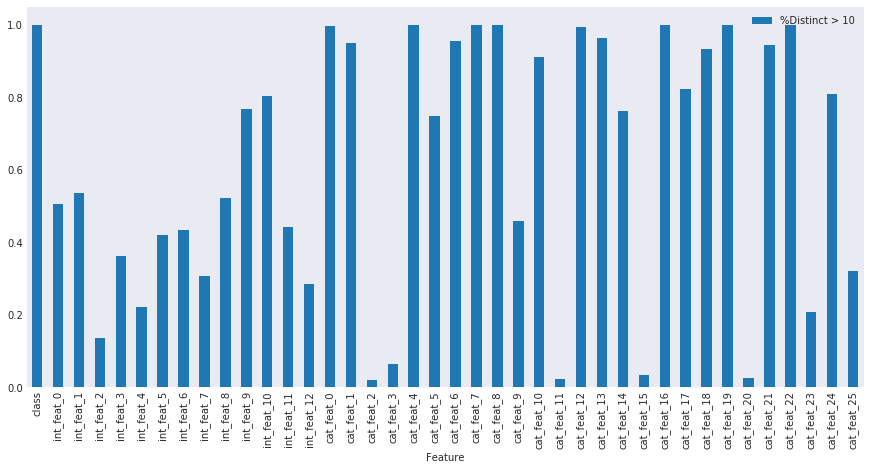

In [190]:
pd_df.plot(x="Feature", y=["%Distinct > 10"], kind='bar', figsize=(15,7))

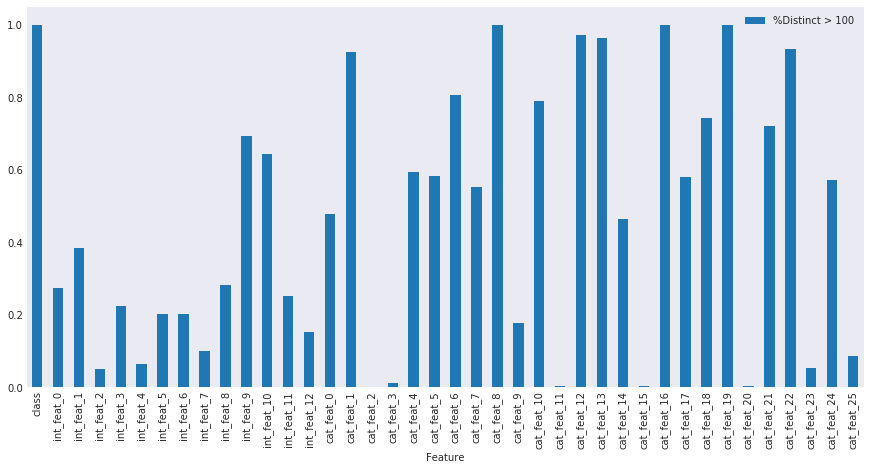

In [191]:
pd_df.plot(x="Feature", y=["%Distinct > 100"], kind='bar', figsize=(15,7))

## How Many Missing Values in Each Column?

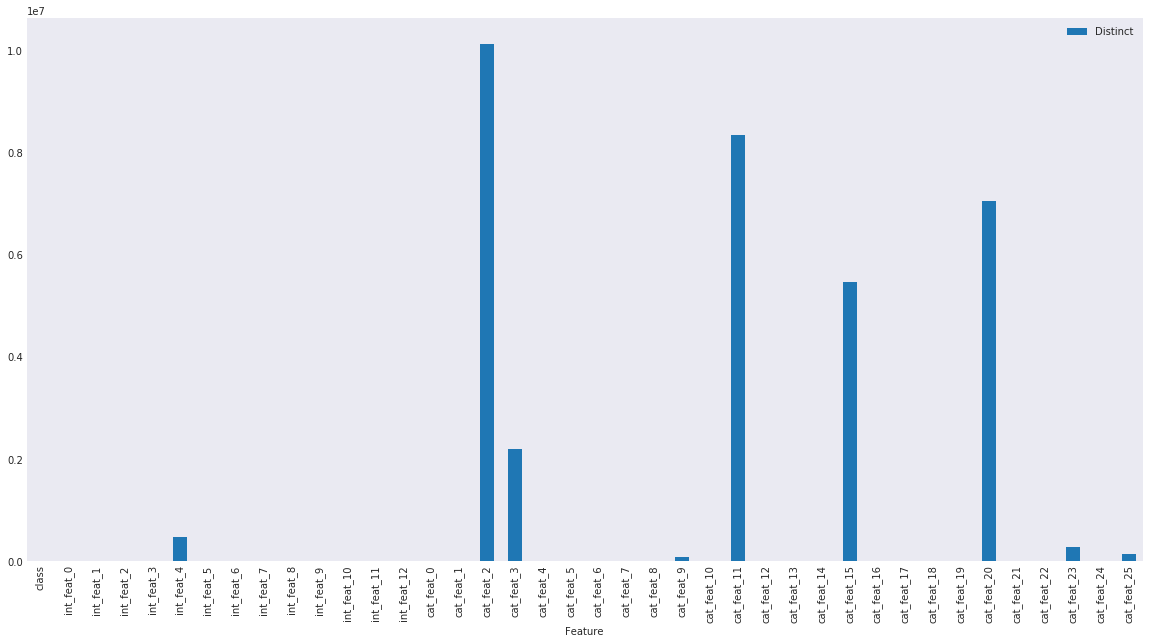

In [186]:
# pd_df = pd_df.set_index('Feature')
pd_df.plot(x="Feature", y=["Distinct"], kind='bar', figsize=(20,10))

In [ ]:
null_values = [new_columns_df.filter((new_columns_df[c].isNull()) | (new_columns_df[c] == "")).count() for c in new_columns_df.columns]

In [168]:
total_rows = new_columns_df.count()

In [128]:
eda_df = spark.createDataFrame(zip(column_names, distinct_count, null_values), ['Feature', 'Distinct', 'Null Count'])

In [129]:
eda_df = eda_df.withColumn('Null %', col('Null Count')/total_rows)

In [164]:
eda_df.groupBy().sum("Distinct").collect()

[Row(sum(Distinct)=34290908)]

In [130]:
eda_df.show(40)

+-----------+--------+----------+-------------------+
|    Feature|Distinct|Null Count|             Null %|
+-----------+--------+----------+-------------------+
|      class|       2|         0|                0.0|
| int_feat_0|     649|  20793556|0.45360550011794126|
| int_feat_1|    9364|         0|                0.0|
| int_feat_2|   14746|   9839447| 0.2146447330759095|
| int_feat_3|     490|   9937369| 0.2167808736082239|
| int_feat_4|  476707|   1183117|0.02580936028849699|
| int_feat_5|   11618|  10252328| 0.2236516144623446|
| int_feat_6|    4142|   1982866|0.04325565687739325|
| int_feat_7|    1373|     22773|4.96786507040252E-4|
| int_feat_8|    7275|   1982866|0.04325565687739325|
| int_feat_9|      13|  20793556|0.45360550011794126|
|int_feat_10|     169|   1982866|0.04325565687739325|
|int_feat_11|     407|  35071652| 0.7650780965709951|
|int_feat_12|    1376|   9937369| 0.2167808736082239|
| cat_feat_0|    1460|         0|                0.0|
| cat_feat_1|     583|      

In [136]:
positive_ctr = new_columns_df.filter(new_columns_df['class'] == '1').count()

In [137]:
positive_ctr

11745438

In [133]:
negative_ctr = new_columns_df.filter(new_columns_df['class'] == 0).count()

In [134]:
negative_ctr

34095179

In [12]:
toy.dtypes

0    int64
1    int64
2    int64
dtype: object

In [247]:
toy_df = spark.createDataFrame([
    [1, "a", "c"],
    [2, "a", "d"],
    [3, "b", "c"],
    [4, "d", "a"],
    [5, "e", "a"],
    [1, "a", "c"],
    [2, "a", "d"],
    [3, "b", "c"],
    [4, "e", "a"],
    [5, "e", "a"]
])

In [216]:
from pyspark.sql.functions import grouping

new_df = toy_df.cube('_2').agg(count('_2')).select("count(_2)")

In [254]:
cols = ["_2", "_3"]
count_dfs = [toy_df.groupBy(c).count() for c in cols]
for count_df in count_dfs:
    count_df.show()
# [[count_df.filter(condition).count() for condition in filters]
# [ toy_df.groupBy('_2').count().filter("count >= 2").show()

+---+-----+
| _2|count|
+---+-----+
|  e|    3|
|  d|    1|
|  b|    2|
|  a|    4|
+---+-----+

+---+-----+
| _3|count|
+---+-----+
|  d|    2|
|  c|    4|
|  a|    4|
+---+-----+



In [258]:
[[df.filter(condition).count() for condition in filters] for df in count_dfs]

[[3, 1, 0], [3, 2, 0]]

In [262]:
count_dfs = [new_columns_df.groupBy(c).count() for c in cat_column_names]
count_dfs[0].show()

+----------+-----+
|cat_feat_0|count|
+----------+-----+
|  a802ce3c|  560|
|  b9179aaa|   70|
|  4a0593ee|   70|
|  b17fad8e|   70|
|  ba9a5693|   40|
|  cd3695ae|10220|
|  7ceef477| 8614|
|  3205b8bc|  140|
|  aa6e9735|   70|
|  a3259f78|   70|
|  b2ac6ea7|   70|
|  22cd0fd5|  330|
|  decf6fa6| 6945|
|  40e1377d|  800|
|  45dc7070|  470|
|  d4682c8d|   70|
|  d5ce4bca|  350|
|  95d53c03|  140|
|  6be8853f|   70|
|  dfc12ca5|   70|
+----------+-----+
only showing top 20 rows



In [263]:
[[df.filter(condition).count() for condition in filters] for df in count_dfs]

[[1457, 700, 212],
 [554, 539, 481],
 [193948, 21054, 2584],
 [138800, 23838, 3555],
 [305, 181, 72],
 [18, 14, 11],
 [11969, 10102, 5276],
 [633, 350, 119],
 [3, 3, 3],
 [42645, 16432, 4408],
 [5177, 4495, 3105],
 [192772, 21497, 2651],
 [3174, 3102, 2554],
 [26, 26, 25],
 [11421, 6966, 3002],
 [181074, 22553, 3014],
 [10, 10, 10],
 [4653, 3275, 1685],
 [2031, 1612, 822],
 [4, 4, 4],
 [189656, 21967, 2754],
 [17, 13, 9],
 [15, 14, 14],
 [59696, 15130, 3072],
 [85, 60, 42],
 [45570, 12295, 2291]]

In [240]:
toy_df.groupBy('_3').count().filter("count >= 2").show()

+---+-----+
| _3|count|
+---+-----+
|  c|    2|
|  a|    2|
+---+-----+



In [228]:
toy_df.agg(countDistinct('_2')).show()

+------------------+
|count(DISTINCT _2)|
+------------------+
|                 4|
+------------------+



In [238]:
toy_df.describe().show()

+-------+------------------+----+----+
|summary|                _1|  _2|  _3|
+-------+------------------+----+----+
|  count|                 5|   5|   5|
|   mean|               3.0|null|null|
| stddev|1.5811388300841898|null|null|
|    min|                 1|   a|   a|
|    max|                 5|   e|   d|
+-------+------------------+----+----+



In [218]:
new_df.filter(new_df["count(_2)"] >= 2).show()

+---------+
|count(_2)|
+---------+
|        2|
|        5|
+---------+



In [236]:
from pyspark.sql.functions import mean, sum, max, col

df = sc.parallelize([(1, 3.0), (1, 3.0), (2, -5.0)]).toDF(["k", "v"])
groupBy = ["k"]
aggregate = ["v"] 
funs = [mean, sum, max]

exprs = [f(col(c)) for f in funs for c in aggregate]

# or equivalent df.groupby(groupBy).agg(*exprs)
df.groupby(*groupBy).agg(*exprs).show()

+---+------+------+------+
|  k|avg(v)|sum(v)|max(v)|
+---+------+------+------+
|  1|   3.0|   6.0|   3.0|
|  2|  -5.0|  -5.0|  -5.0|
+---+------+------+------+



# Hashing

Can we just use this? Or do we want hash size to be a parameter?

In [262]:
hash("I:368")

-1735128748767905266

Do we need to normalize the data and does this make it hard?
Does it help to have dimensionality reduction of the integers such as binning them?

In [226]:
hash(f"I:{int(np.log(22000000))}")

-8377462871896521829

In [246]:
def hash_fn(value, hash_size):
    return hash(value) % hash_size

In [260]:
hash_fn("I:23080691", 1000000)

626094

In [257]:
hash("1")

5857543128032591645

In [253]:
from sklearn.feature_extraction import FeatureHasher
hasher = FeatureHasher(n_features=1000000, input_type="string")
hasher.transform(["I:368"])

<1x1000000 sparse matrix of type '<class 'numpy.float64'>'
	with 5 stored elements in Compressed Sparse Row format>

In [290]:
train = ["1", "2", "3", "4", "3", "4", "1", "a0"]
hasher = FeatureHasher(n_features=10, input_type="string", alternate_sign=False)
hasher.transform(train).toarray()

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [302]:
hasher_df = spark.createDataFrame([["1", 2],["2", 3],["3", 1]])

In [306]:
from pyspark.ml.feature import FeatureHasher
hasher = FeatureHasher()
hasher.setInputCols(["_1", "_2"])
hasher.setOutputCol("features")

hasher.transform(hasher_df).show()

+---+---+--------------------+
| _1| _2|            features|
+---+---+--------------------+
|  1|  2|(262144,[127086,1...|
|  2|  3|(262144,[157696,1...|
|  3|  1|(262144,[38866,15...|
+---+---+--------------------+



In [305]:
hasher.explainParams()

"categoricalCols: numeric columns to treat as categorical (undefined)\ninputCols: input column names. (current: ['_1', '_2'])\nnumFeatures: number of features. (default: 262144)\noutputCol: output column name. (default: FeatureHasher_44b2b55806f05c5dd558__output, current: features)"